# Oxford5k VLAD anf Fisher Vector Retrieval Demo

This notebook demonstrates how to:
1. Load the Oxford Flower dataset.
2. Extract deep convolutional features (last conv layer) from a pretrained model.
3. Train a VLAD model on these deep features.
4. Perform image retrieval queries.
5. Show the effect of PCA (reducing features by half before VLAD) on retrieval performance.
6. An analogous procedure is made for Fisher Vectors




## 1. Imports and Setup

In [1]:
import os

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm

# Our library imports
from src.features._features import DeepConvFeatureExtractor, SIFT, RootSIFT
from src.metrics.vlad import VLADEncoder
from src.metrics.fisher_vector import FisherVectorEncoder
from src.datasets import OxfordFlowerDataset  # We'll create this in a moment
from src.config import DEVICE, ROOT
from src.utils import *

print("Device in use:", DEVICE)

Device used: cuda
2025-01-05 13:47:25,479 - numexpr.utils - INFO - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-01-05 13:47:25,480 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
Device in use: cuda


### Hyperparameters

**Note**: training k-means models takes quite a bit of time. In this notebook, a single `n_clusters = 256` will be used. Add more values to `NUM_CLUSTERS` to experiment with different cluster sizes.

In [2]:
NUM_CLUSTERS = 256
IMAGE_SIZE = (224, 224)
DIM_REDUCTION_FACTOR = 2
SAVE_DATA = True # Adjust if you don't wish to save computed VLAD vectors (though, they are needed for the demonstrations later on)

## 2. Declare the Oxford Flower Dataset

The VGG16 model requires input images as tensors and of size 224x224. To ensure compatibility, the transformations below are applied to the dataset.

In [4]:
transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE)
    ]
)

train_dataset = OxfordFlowerDataset(transform=transformer, purpose='train')
val_dataset = OxfordFlowerDataset(transform=transformer, purpose='validation')
print("Number of images in the dataset:", len(train_dataset))

Number of images in the dataset: 6149


### Plot some images

Image size: torch.Size([3, 224, 224])


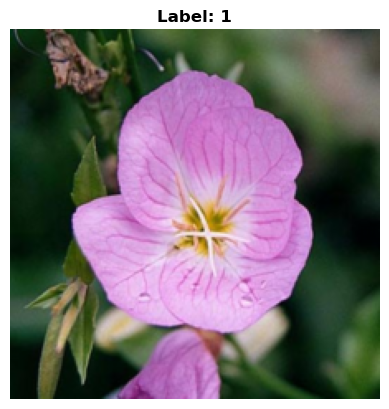

Image size: torch.Size([3, 224, 224])


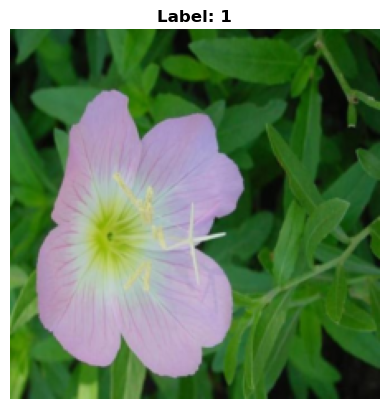

Image size: torch.Size([3, 224, 224])


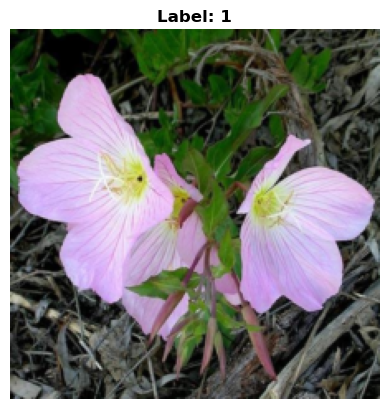

Image size: torch.Size([3, 224, 224])


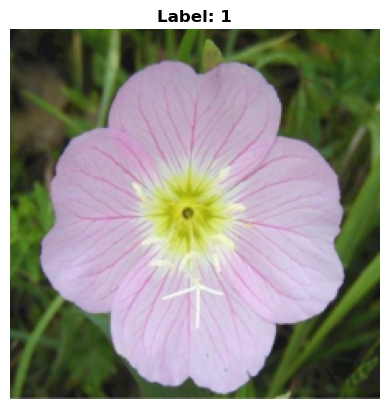

Image size: torch.Size([3, 224, 224])


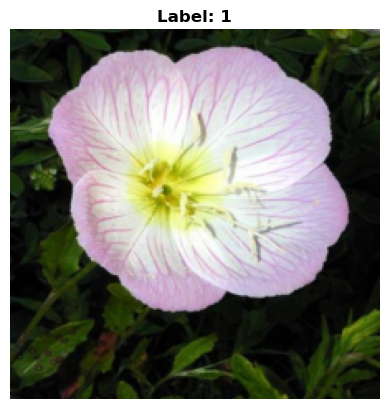

In [5]:
for i in range(5):
    img, label, _ = train_dataset[i]
    print("Image size:", img.shape)
    plot_image(img, title = f"Label: {label}")

### 3. Extract deep convolutional features

We use `DeepConvFeatureExtractor` from our code. For demonstration, we'll pick `vgg16` and the last conv layer.


In [6]:
extractor = DeepConvFeatureExtractor(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1,  # Last conv layer
    append_spatial_coords=True,
    device=DEVICE
)

2025-01-05 13:47:32,845 - Feature_Extractor - INFO - Device used: cuda
2025-01-05 13:47:32,848 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Extract features

**WARNING**: This loads all images and feature maps into memory. Make sure your computer can handle the data.


In [7]:
images = []
labels = []
paths = []
features = []

for i in tqdm(range(len(train_dataset))):
    img, label, path = train_dataset[i]
    img = img.to(DEVICE)
    feature = extractor(img)
    images.append(img)
    labels.append(label)
    paths.append(path)
    features.append(feature)

features = np.vstack(features)
labels = np.array(labels)

100%|██████████| 6149/6149 [01:30<00:00, 67.59it/s]


## **4. Training VLAD Model**
We'll train the K-Means model, which is essential for the VLAD Encoding model. This might take a while.

In [10]:
kmeans_model_no_pca = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans_model_no_pca.fit(features)
save_model(kmeans_model_no_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [9]:
kmeans_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Declare the VLAD encoder (no PCA)

In [10]:
vlad_encoder_no_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_no_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

if SAVE_DATA:
    vlad_vectors = vlad_encoder_no_pca.transform(images)
    vlad_data = {os.path.basename(path): vlad_vectors[i] for i, (image, _, path) in enumerate(train_dataset)}
    save_to_hdf5(f'{ROOT}/res/oxford_flower_dset_vlad_{NUM_CLUSTERS}_clusters_pca_False_deep_features_vgg16.h5', vlad_data)

Similar to above, but here, the dimension of each feature vector is reduced `by half` using `PCA`.

In [11]:
dim_pca_vlad = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_vlad = PCA(n_components=dim_pca_vlad).fit(features)
features_pca_vlad = pca_model_vlad.transform(features)
save_model(pca_model_vlad, f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_vlad}.pkl")

kmeans_model_pca = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans_model_pca.fit(features_pca_vlad)
save_model(kmeans_model_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [12]:
dim_pca_vlad = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_vlad = load_model(f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_vlad}.pkl")
kmeans_model_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Declare the VLAD encoder (with PCA)

In [13]:
vlad_encoder_with_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_vlad
)

if SAVE_DATA:
    vlad_vectors_pca = vlad_encoder_with_pca.transform(images)
    vlad_data_pca = {os.path.basename(path): vlad_vectors_pca[i] for i, (image, _, path) in enumerate(train_dataset)}
    save_to_hdf5(f'{ROOT}/res/oxford_flower_dset_vlad_{NUM_CLUSTERS}_clusters_pca_True_deep_features_vgg16.h5', vlad_data_pca)

## **5. Compare some images**

We will now use the trained VLAD encoders to compute similarity between some images.

2025-01-05 14:02:13,788 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


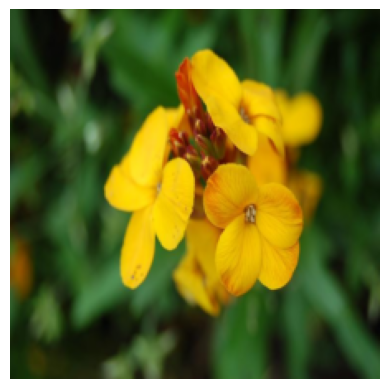

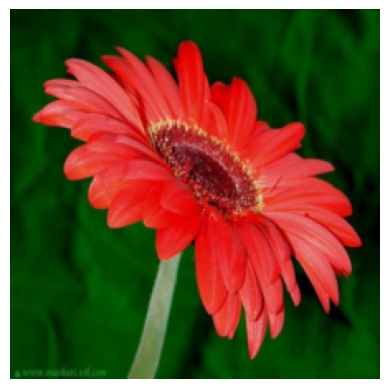

In [19]:
image_1, label_1, path_1 = train_dataset[2005]
image_2, label_2, path_2 =  val_dataset[401]
plot_image(image_1)
plot_image(image_2)

Now, we compare the two images. `cosine similarity` is used in this case.

In [15]:
sim_with_pca = vlad_encoder_with_pca.compare(image_1, image_2)
print("Similarity Score, with PCA: ", sim_with_pca)
sim_without_pca = vlad_encoder_no_pca.compare(image_1, image_2)
print("Similarity Score, without PCA: ", sim_without_pca)

Similarity Score, with PCA:  -0.0004881620407104492
Similarity Score, without PCA:  0.033484119921922684


## **6. Fetch the most similar image in the dataset, given a query image**

**NOTE**: This only works if you have previously saved the computed vectors (by setting `SAVE_DATA = True`.

First, we will load the data.

In [16]:
vlad_data = load_hdf5(f'{ROOT}/res/oxford_flower_dset_vlad_{NUM_CLUSTERS}_clusters_pca_False_deep_features_vgg16.h5')
vlad_data_pca = load_hdf5(f'{ROOT}/res/oxford_flower_dset_vlad_{NUM_CLUSTERS}_clusters_pca_True_deep_features_vgg16.h5')

Now, we will select an image in the validation dataset, on which the model is not yet trained:

In [8]:
query_image, query_label, query_path =  val_dataset[101]

### Utils function to retrieve the most similar image based on `cosine_similarity` score between two images

In [9]:
def retrieve_most_similar(uploaded_image: np.ndarray,
                          dataset: dict[str, Any],
                          encoder) -> tuple[str, float]:
    """
    Retrieve the most similar image from a dataset based on cosine similarity scores.

    This function takes an image array, a dataset of images represented as
    vectors, and an encoder. It computes the similarity scores between the
    uploaded image and each image vector in the dataset using the cosine similarity
    metric. The function then returns the dataset's image most similar to the
    uploaded image along with the corresponding similarity score.

    :param uploaded_image: The image provided by the user for comparison.
    :param dataset: A dictionary where keys are image file paths, and values are their corresponding vector representations.
    :param encoder: The encoder used
    :return: A tuple containing the path of the most similar image and its similarity score.
    """
    vectors, paths = np.array(list(dataset.values())), list(dataset.keys())
    query_vector = encoder.compute_vector(uploaded_image)
    scores = cosine_similarity(query_vector, vectors)

    max_idx = np.argmax(scores)
    return paths[max_idx], scores[0, max_idx]


Retrieve most similar images using the results saved. We will see how it works, with and without PCA.

In [19]:
most_similar_image_path_pca, score_pca = retrieve_most_similar(query_image, vlad_data_pca, vlad_encoder_with_pca)
most_similar_image_label_pca = train_dataset.labels[train_dataset.image_paths.index(rf"{ROOT}/oxford_flower_dataset/images\{most_similar_image_path_pca}")]
most_similar_image_path_no_pca, score_no_pca = retrieve_most_similar(query_image, vlad_data, vlad_encoder_no_pca)
most_similar_image_label_no_pca = train_dataset.labels[train_dataset.image_paths.index(rf"{ROOT}/oxford_flower_dataset/images\{most_similar_image_path_no_pca}")]
print("Highest similarity score, with PCA: ", score_pca)
print("Highest similarity score, no PCA: ", score_no_pca)

Highest similarity score, with PCA:  0.09654633
Highest similarity score, no PCA:  0.17075431


### Let's plot both images next to each other.
a) Using Model trained on data with PCA

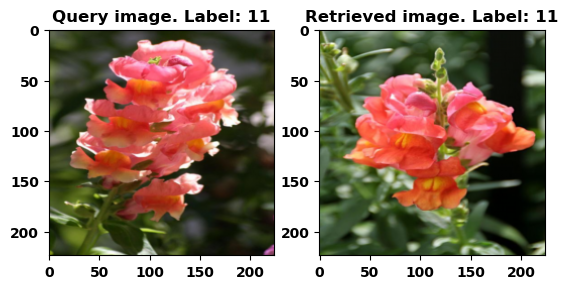

In [20]:
most_similar_image_pca = transformer(cv2.cvtColor(cv2.imread(f"{ROOT}/oxford_flower_dataset/images/{most_similar_image_path_pca}"), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 1)
plt.imshow(query_image.permute(1, 2, 0).clip(0, 1))
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_pca.permute(1, 2, 0).clip(0, 1))
plt.title(f"Retrieved image. Label: {most_similar_image_label_pca}")

plt.show()

b) Using model trained on full data

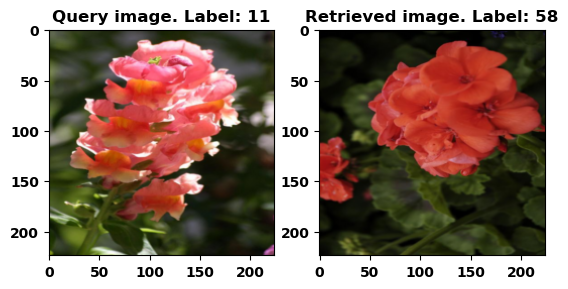

In [21]:
most_similar_image_no_pca = transformer(cv2.cvtColor(cv2.imread(f"{ROOT}/oxford_flower_dataset/images/{most_similar_image_path_no_pca}"), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 1)
plt.imshow(query_image.permute(1, 2, 0).clip(0, 1))
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_no_pca.permute(1, 2, 0).clip(0, 1))
plt.title(f"Retrieved image. Label: {most_similar_image_label_no_pca}")

plt.show()

## **7. Similar to above, we will do the exact things for the Fisher Vector**

The implementation for both VLAD and Fisher Vectors are identical. After all, VLAD is simply a simplified case of Fisher Vector.

### Fit GMM model

In [24]:
gmm_model_no_pca = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='diag', random_state=42)
gmm_model_no_pca.fit(features)
save_model(gmm_model_no_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [10]:
gmm_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Instantiate Fisher Vector Encoder without PCA

In [11]:
fisher_encoder_no_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_no_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

if SAVE_DATA:
    fisher_vectors = fisher_encoder_no_pca.transform(images)
    fisher_data = {os.path.basename(path): fisher_vectors[i] for i, (image, _, path) in enumerate(train_dataset)}
    save_to_hdf5(f'{ROOT}/res/oxford_flower_dset_fisher_{NUM_CLUSTERS}_clusters_pca_False_deep_features_vgg16.h5', fisher_data)

### Using PCA to reduce features by half

In [24]:
dim_pca_fisher = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_fisher = PCA(n_components=dim_pca_fisher).fit(features)
features_pca_fisher = pca_model_fisher.transform(features)
save_model(pca_model_fisher, f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_fisher}.pkl")

gmm_model_pca = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='diag', random_state=42)
gmm_model_pca.fit(features_pca_fisher)
save_model(gmm_model_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [16]:
dim_pca_fisher = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_fisher = load_model(f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_fisher}.pkl")
gmm_model_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Instantiate Fisher Vector Encoder with PCA

In [17]:
fisher_encoder_with_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_fisher,
)

if SAVE_DATA:
    fisher_vectors_pca = fisher_encoder_with_pca.transform(images)
    fisher_data_pca = {os.path.basename(path): fisher_vectors_pca[i] for i, (image, _, path) in enumerate(train_dataset)}
    save_to_hdf5(f'{ROOT}/res/oxford_flower_dset_fisher_{NUM_CLUSTERS}_clusters_pca_True_deep_features_vgg16.h5', fisher_data_pca)

### Compute similarity of two images

In [20]:
image_similarity_with_pca = fisher_encoder_with_pca.compare(image_1, image_2)
image_similarity_without_pca = fisher_encoder_no_pca.compare(image_1, image_2)
print("Fisher Similarity Score, with PCA: ", image_similarity_with_pca)
print("Fisher Similarity Score, without PCA: ", image_similarity_without_pca)

Fisher Similarity Score, with PCA:  0.006492069336617038
Fisher Similarity Score, without PCA:  0.15985453373526606


### Load the data

In [21]:
fisher_data = load_hdf5(f'{ROOT}/res/oxford_flower_dset_fisher_{NUM_CLUSTERS}_clusters_pca_False_deep_features_vgg16.h5')
fisher_data_pca = load_hdf5(f'{ROOT}/res/oxford_flower_dset_fisher_{NUM_CLUSTERS}_clusters_pca_True_deep_features_vgg16.h5')

### Query images

In [22]:
most_similar_image_path_pca, score_pca = retrieve_most_similar(query_image, fisher_data_pca, fisher_encoder_with_pca)
most_similar_image_label_pca = train_dataset.labels[
    train_dataset.image_paths.index(rf"{ROOT}/oxford_flower_dataset/images\{most_similar_image_path_pca}")]
most_similar_image_path_no_pca, score_no_pca = retrieve_most_similar(query_image, fisher_data, fisher_encoder_no_pca)
most_similar_image_label_no_pca = train_dataset.labels[
    train_dataset.image_paths.index(rf"{ROOT}/oxford_flower_dataset/images\{most_similar_image_path_no_pca}")]
print("Highest similarity score, with PCA: ", score_pca)
print("Highest similarity score, no PCA: ", score_no_pca)

Highest similarity score, with PCA:  0.06263028436829911
Highest similarity score, no PCA:  0.34751409120295607


### Let's plot both images next to each other.
a) Using Model trained on Data with PCA

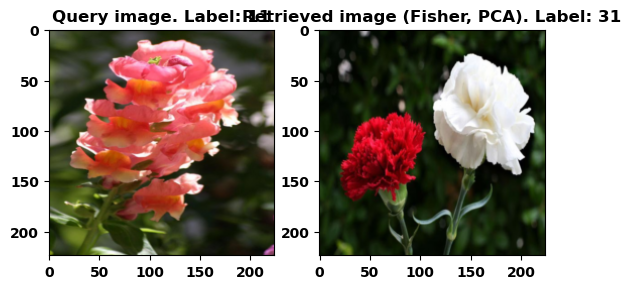

In [23]:
most_similar_image_pca = transformer(
    cv2.cvtColor(cv2.imread(f"{ROOT}/oxford_flower_dataset/images/{most_similar_image_path_pca}"), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 1)
plt.imshow(query_image.permute(1, 2, 0).clip(0, 1))
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_pca.permute(1, 2, 0).clip(0, 1))
plt.title(f"Retrieved image (Fisher, PCA). Label: {most_similar_image_label_pca}")

plt.show()

b) Using Model trained on full data

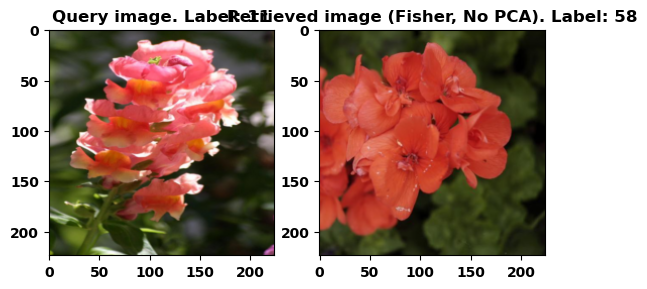

In [24]:
most_similar_image_no_pca = transformer(
    cv2.cvtColor(cv2.imread(f"{ROOT}/oxford_flower_dataset/images/{most_similar_image_path_no_pca}"),
                 cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 1)
plt.imshow(query_image.permute(1, 2, 0).clip(0, 1))
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_no_pca.permute(1, 2, 0).clip(0, 1))
plt.title(f"Retrieved image (Fisher, No PCA). Label: {most_similar_image_label_no_pca}")

plt.show()

## **7. Conclusion**

We have demonstrated:
1. Training VLAD on deep embeddings from the last conv layer.
2. Clustering images for different cluster sizes.
3. Comparing PCA vs. No PCA approaches.
4. Saving final VLAD vectors for future retrieval or clustering tasks.
